# Загрузка данных

In [1]:
import nibabel as nib
import numpy as np
import os
from tqdm import tqdm
from skimage.transform import resize

data_dir = './data/'
target_shape = (128, 128, 64)

def load_mri_images(data_dir):
    images = []
    file_list = [f for f in os.listdir(data_dir) if f.endswith('.nii') or f.endswith('.nii.gz')]
    
    for file_name in tqdm(file_list, desc="Загрузка MRI-изображений"):
        img_path = os.path.join(data_dir, file_name)
        img = nib.load(img_path)
        img_data = img.get_fdata()

        img_resized = resize(img_data, target_shape, anti_aliasing=True)

        # Преобразуем в 1D-вектор
        img_vector = img_resized.flatten()
        images.append(img_vector)
    
    return np.array(images)

mri_data = load_mri_images(data_dir)


Загрузка MRI-изображений: 100%|██████████| 582/582 [01:59<00:00,  4.85it/s]


In [27]:
mri_data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15093398, 0.06666725, 0.01599847, ..., 0.        , 0.        ,
        0.        ]])

# Топологические методы анализа данных

In [ ]:
!pip install gudhi

In [ ]:
!pip install ripser

In [ ]:
!pip install tadasets

In [7]:
import matplotlib.pyplot as plt
import ripser
import persim
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import gudhi as gd
from gudhi.representations import Landscape, Silhouette, PersistenceImage
import tadasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import networkx as nx

In [43]:
def compute_persistent_homology(data, max_dim=1, max_radius=200.0):  # Снижаем max_dim до 1
    """
    Вычисление персистентных гомологий для данных.
    """
    print("Вычисление персистентных гомологий...")
    
    data_reduced = data
    
    sample_size = min(50, data_reduced.shape[0])
    indices = np.random.choice(data_reduced.shape[0], sample_size, replace=False)
    data_sample = data_reduced[indices]
    
    try:
        # Вычисляем матрицу попарных расстояний
        dist_matrix = squareform(pdist(data_sample))
        
        # Вычисляем персистентные гомологии с меньшим порогом
        diagrams = ripser.ripser(dist_matrix, maxdim=max_dim, distance_matrix=True, thresh=max_radius)['dgms']
        
        print(f"Вычислены диаграммы персистентности для размерностей от 0 до {max_dim}")
        return diagrams
    except Exception as e:
        print(f"Ошибка при вычислении персистентных гомологий: {e}")
        return [np.array([]) for _ in range(max_dim + 1)]


In [ ]:
def visualize_persistence_diagrams(diagrams):
    """
    Визуализация персистентных диаграмм с проверкой на пустые диаграммы.
    """
    fig, axes = plt.subplots(1, len(diagrams), figsize=(15, 5))
    
    for i, diagram in enumerate(diagrams):
        if len(diagrams) == 1:
            ax = axes
        else:
            ax = axes[i]
        
        if len(diagram) > 0:
            persim.plot_diagrams(diagram, ax=ax, labels=[f'H{i}'])
        else:
            ax.plot([0, 1], [0, 1], 'k--')  
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1])
        
        ax.set_title(f'Персистентная диаграмма H{i}')
        ax.set_xlabel('Рождение')
        ax.set_ylabel('Смерть')
    
    plt.tight_layout()
    plt.savefig('persistence_diagrams.png')
    plt.close()
    print("Персистентные диаграммы сохранены в файл persistence_diagrams.png")
    return fig


In [44]:
def compute_topological_features(diagrams, n_landscapes=5, resolution=20):
    """
    Вычисление топологических векторов признаков, с исправленной обработкой формата данных.
    """
    features = []
    
    if all(len(diagram) == 0 for diagram in diagrams):
        print("Все диаграммы пустые, создаем нулевой вектор признаков")
        return np.zeros(10)  
    
    print("Вычисление статистических признаков...")
    for dim, diagram in enumerate(diagrams):
        if len(diagram) == 0:
            features.append(np.zeros(6))  
            continue
        
        persistences = np.array([death - birth for birth, death in diagram if birth != death])
        
        if len(persistences) == 0:
            features.append(np.zeros(6))
            continue
            
        stats = [
            len(persistences), 
            np.sum(persistences),  
            np.mean(persistences),  
            np.std(persistences) if len(persistences) > 1 else 0, 
            np.max(persistences) if len(persistences) > 0 else 0,  
            np.quantile(persistences, 0.75) if len(persistences) > 0 else 0  
        ]
        features.append(np.array(stats))
    
    try:
        for dim, diagram in enumerate(diagrams):
            if len(diagram) == 0 or all(birth == death for birth, death in diagram):
                features.append(np.zeros(resolution * resolution))
                continue
                
            filtered_diagram = np.array([point for point in diagram if point[0] != point[1]])
            
            if len(filtered_diagram) == 0:
                features.append(np.zeros(resolution * resolution))
                continue
                
            pim = persim.PersImage(pixels=(resolution, resolution), spread=0.1)
            img = pim.transform(filtered_diagram)
            features.append(img.flatten())
                
    except Exception as e:
        print(f"Ошибка при создании персистентных изображений: {e}")
    
    if not features:
        return np.zeros(10)
        
    features_arrays = []
    for f in features:
        if isinstance(f, np.ndarray):
            features_arrays.append(f)
        else:
            features_arrays.append(np.array(f).flatten())
    
    try:
        feature_vector = np.concatenate(features_arrays)
    except ValueError as e:
        print(f"Ошибка при объединении признаков: {e}")
        if len(features) > 0 and isinstance(features[0], np.ndarray):
            return features[0]
        return np.zeros(10)
    
    print(f"Создан вектор топологических признаков размерности {feature_vector.shape[0]}")
    
    return feature_vector


In [45]:
def compute_reeb_graph(data, filter_function=None, num_intervals=10):
    """
    Упрощенная версия построения графа Риба для данных.
    """
    print("Построение графа Риба...")
    
    try:
        if filter_function is None:
            # Используем первую главную компоненту как функцию Морса
            pca = PCA(n_components=1)
            filter_values = pca.fit_transform(data).flatten()
        else:
            filter_values = filter_function(data)
        
        f_min, f_max = np.min(filter_values), np.max(filter_values)
        
        intervals = np.linspace(f_min, f_max, num_intervals + 1)
        
        G = nx.Graph()
        
        for i in range(num_intervals):
            a_i, a_i_next = intervals[i], intervals[i+1]
            node_id = f"interval_{i}"
            
            mask = (filter_values >= a_i) & (filter_values < a_i_next)
            points_in_interval = np.where(mask)[0]
            
            G.add_node(node_id, 
                      level=i, 
                      size=len(points_in_interval),
                      filter_value=(a_i + a_i_next)/2)
        
        for i in range(num_intervals-1):
            G.add_edge(f"interval_{i}", f"interval_{i+1}")
        
        print(f"Построен упрощенный граф Риба с {G.number_of_nodes()} вершинами и {G.number_of_edges()} рёбрами")
        return G
    
    except Exception as e:
        print(f"Ошибка при построении графа Риба: {e}")
        G = nx.Graph()
        G.add_node("node1", level=0, size=1, filter_value=0)
        G.add_node("node2", level=1, size=1, filter_value=1)
        G.add_edge("node1", "node2")
        return G


In [46]:
def visualize_reeb_graph(G):
    """
    Визуализация графа Риба с цветовой шкалой.
    """
    plt.figure(figsize=(12, 10))
    
    pos = {}
    for node in G.nodes():
        level = G.nodes[node]['level']
        pos[node] = (np.random.random(), level)
    
    node_colors = [G.nodes[node]['filter_value'] for node in G.nodes()]
    node_sizes = [100 * G.nodes[node]['size'] / max(1, np.max([G.nodes[n]['size'] for n in G.nodes()])) for node in G.nodes()]
    
    norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])  
    
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, 
            edge_color='gray', width=1.0, alpha=0.8, cmap=plt.cm.viridis, 
            vmin=min(node_colors), vmax=max(node_colors))
    
    plt.title('Граф Риба для МРТ-данных')
    plt.colorbar(sm, label='Значение фильтра')
    plt.tight_layout()
    plt.savefig('reeb_graph.png')
    plt.close()
    print("Граф Риба сохранен в файл reeb_graph.png")


In [ ]:
def visualize_topological_features_on_mri(diagram, data_sample, indices, threshold=0.7):
    """
    Упрощенная визуализация МРТ-снимков без привязки к топологическим особенностям.
    """
    try:
        # Выбираем один образец для визуализации
        if len(data_sample) > 0:
            sample_idx = np.random.choice(len(data_sample))
            
            mri_3d = data_sample[sample_idx].reshape(target_shape)
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(mri_3d[:, :, mri_3d.shape[2]//2], cmap='gray')
            axes[0].set_title('Аксиальный срез')
            
            axes[1].imshow(mri_3d[:, mri_3d.shape[1]//2, :], cmap='gray')
            axes[1].set_title('Сагиттальный срез')
            
            axes[2].imshow(mri_3d[mri_3d.shape[0]//2, :, :], cmap='gray')
            axes[2].set_title('Корональный срез')
            
            if len(diagram) == 0:
                for ax in axes:
                    ax.set_xlabel('Топологические особенности не обнаружены')
            else:
                for ax in axes:
                    ax.set_xlabel('МРТ-снимок')
            
            plt.tight_layout()
            plt.savefig('mri_visualization.png')
            plt.close()
            print("МРТ-снимок сохранен в файл mri_visualization.png")
    
    except Exception as e:
        print(f"Ошибка при визуализации МРТ: {e}")


In [47]:
def visualize_reeb_graph_simple(G):
    """
    Упрощенная визуализация графа Риба без цветовой шкалы.
    """
    plt.figure(figsize=(10, 8))
    
    pos = {}
    for node in G.nodes():
        level = G.nodes[node]['level']
        pos[node] = (np.random.random(), level)
    
    nx.draw(G, pos, with_labels=True, node_color='skyblue', 
            edge_color='gray', width=1.0, alpha=0.8)
    
    plt.title('Граф Риба для МРТ-данных')
    plt.tight_layout()
    plt.savefig('reeb_graph.png')
    plt.close()
    print("Граф Риба сохранен в файл reeb_graph.png")



Анализ МРТ-данных с помощью топологических методов (выборка 50 образцов)...
Вычисление персистентных гомологий...
Вычислены диаграммы персистентности для размерностей от 0 до 1
Персистентные диаграммы сохранены в файл persistence_diagrams.png
Вычисление статистических признаков...
PersImage(pixels=(20, 20), spread=0.1, specs=None, kernel_type="gaussian", weighting_type="linear")
Создан вектор топологических признаков размерности 812
Построение графа Риба...


/Users/dasidorov03/.pyenv/versions/3.11.4/lib/python3.11/site-packages/persim/visuals.py:155: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([x_down, x_up])
/Users/dasidorov03/.pyenv/versions/3.11.4/lib/python3.11/site-packages/persim/visuals.py:156: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([y_down, y_up])


Построен упрощенный граф Риба с 10 вершинами и 9 рёбрами
Ошибка при визуализации графа Риба: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
Граф Риба сохранен в файл reeb_graph.png
Нет топологических особенностей для визуализации


/var/folders/5q/n0q433m534zf37kj89fdxpbrpym2wh/T/ipykernel_99390/2366753153.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Сравнение МРТ сохранено в файл mri_comparison_no_features.png

Топологический анализ МРТ-данных завершен!
Получены топологические признаки размерности 812


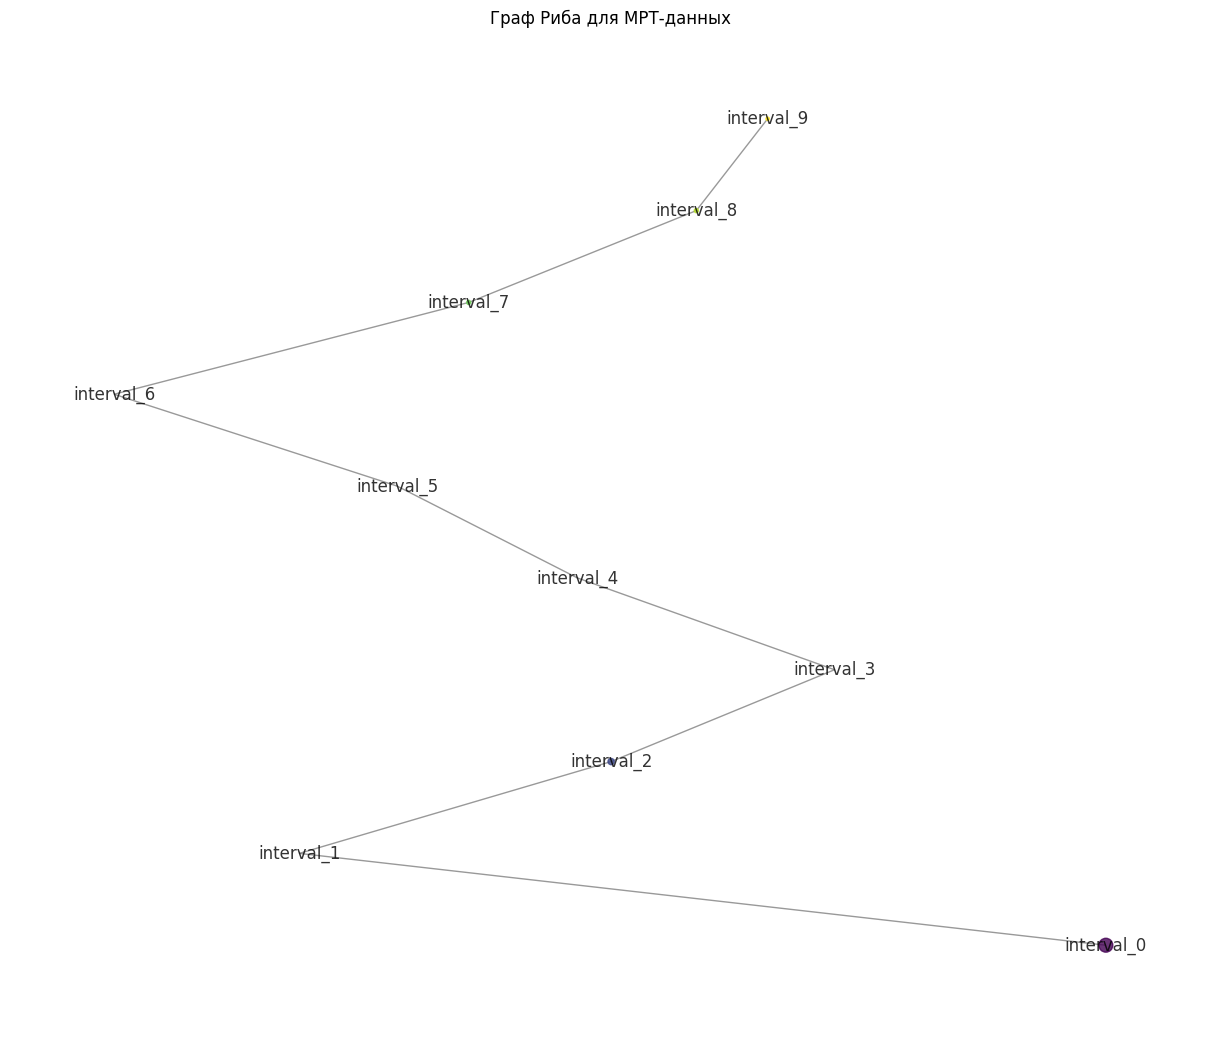

In [48]:
def analyze_mri_with_topology(mri_data, sample_size=50):
    """
    Анализ МРТ-данных с помощью топологических методов.
    
    Параметры:
    - mri_data: МРТ-данные
    - sample_size: размер выборки для анализа (если данных много)
    
    Возвращает:
    - top_features: топологические признаки
    """
    print(f"\nАнализ МРТ-данных с помощью топологических методов (выборка {sample_size} образцов)...")
    
    if len(mri_data) > sample_size:
        indices = np.random.choice(len(mri_data), sample_size, replace=False)
        data_sample = mri_data[indices]
    else:
        data_sample = mri_data
        indices = np.arange(len(mri_data))
    
    # Вычисляем персистентные гомологии
    diagrams = compute_persistent_homology(data_sample)
    
    # Визуализируем персистентные диаграммы
    visualize_persistence_diagrams(diagrams)
    
    # Вычисляем топологические признаки
    top_features = compute_topological_features(diagrams)
    
    # Строим граф Риба
    reeb_graph = compute_reeb_graph(data_sample)
    
    # Визуализируем граф Риба
    try:
        visualize_reeb_graph(reeb_graph)
    except Exception as e:
        print(f"Ошибка при визуализации графа Риба: {e}")
        visualize_reeb_graph_simple(reeb_graph)
    
    visualize_topological_features_on_mri(diagrams[1], data_sample, indices)
    
    return top_features

if __name__ == "__main__":
    import warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    # Анализируем МРТ-данные с помощью топологических методов
    top_features = analyze_mri_with_topology(mri_data)
    top_features = np.nan_to_num(top_features)
    
    print("\nТопологический анализ МРТ-данных завершен!")
    print(f"Получены топологические признаки размерности {len(top_features)}")